**VGG16**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import torch.optim as optim

In [4]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 250
print('using device:', device)

using device: cuda


In [5]:
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224, 224))])

In [ ]:
NUM_TRAIN = 49000

# CIFAR100: 60000 32x32 color images in 100 classes, with 500 training and 100 test images per class

cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

loader_train = DataLoader(cifar100_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

loader_val = DataLoader(cifar100_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

loader_test = DataLoader(cifar100_test, batch_size=64)

100%|██████████| 169001437/169001437 [00:01<00:00, 99043440.24it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


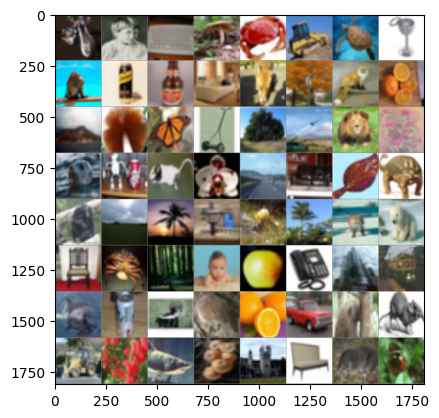

In [ ]:
# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [ ]:
#Checking the shape of the images
print(images.shape)

torch.Size([64, 3, 224, 224])


In [6]:
loss_history = []
time_history = []

In [10]:
learning_rate = 3e-3
# batch_size = 16

model = nn.Sequential(
    # [3,224,224]

    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),    #[64, 224, 224]
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),   #[64, 224, 224]
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 2, stride = 2),               #[64, 112, 112]

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  #[128, 112, 112]
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #[128, 112, 112]
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),               #[128, 56, 56]

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #[256, 56, 56]
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #[256, 56, 56]
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #[256, 56, 56]
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),               #[256, 28, 28]
 
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #[512, 28, 28]
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #[512, 28, 28]
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #[512, 28, 28]
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),               #[512, 14, 14]

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #[512, 14, 14]
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #[512, 14, 14]
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #[512, 14, 14]
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),               #[512, 7, 7]

    nn.Flatten(),                 #[512*7*7]
    nn.Dropout(0.5),
    nn.Linear(7*7*512, 4096),     #[4096]
    nn.ReLU(),

    nn.Dropout(0.5),
    nn.Linear(4096, 4096),        #[4096]
    nn.ReLU(),

    nn.Linear(4096, 100)          #[100]

)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
def train_model(model, optimizer, epochs=1):

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        import time
        tic = time.time()
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_history.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % ((e+1), t, loss.item()))
                check_accuracy(loader_val, model)
                print()
        toc = time.time()
        print('Epoch %d, Time %fmin' % ((e+1), (toc-tic)/60))
        time_history.append((toc-tic)/60)
        print()

In [ ]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
#Training and checking accuracy on val set
train_model(model, optimizer, epochs = 20)

Epoch 1, Iteration 0, loss = 4.6235
Checking accuracy on validation set
Got 10 / 1000 correct (1.00)

Epoch 1, Iteration 250, loss = 3.9827
Checking accuracy on validation set
Got 63 / 1000 correct (6.30)

Epoch 1, Iteration 500, loss = 3.6335
Checking accuracy on validation set
Got 121 / 1000 correct (12.10)

Epoch 1, Iteration 750, loss = 3.6444
Checking accuracy on validation set
Got 146 / 1000 correct (14.60)

Epoch 1, Time 13.172917min

Epoch 2, Iteration 0, loss = 3.5868
Checking accuracy on validation set
Got 172 / 1000 correct (17.20)

Epoch 2, Iteration 250, loss = 3.2227
Checking accuracy on validation set
Got 192 / 1000 correct (19.20)

Epoch 2, Iteration 500, loss = 3.0181
Checking accuracy on validation set
Got 245 / 1000 correct (24.50)

Epoch 2, Iteration 750, loss = 2.8930
Checking accuracy on validation set
Got 260 / 1000 correct (26.00)

Epoch 2, Time 13.083989min

Epoch 3, Iteration 0, loss = 2.3565
Checking accuracy on validation set
Got 274 / 1000 correct (27.40)



In [ ]:
#Checking accuracy on Test set
import time
test_start_time = time.time()
check_accuracy(loader_test, model) 
test_end_time = time.time()
print('Total time taken to run test images: %fmin' %((test_end_time - test_start_time)/60))

Checking accuracy on test set


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Got 5754 / 10000 correct (57.54)
Total time taken to run test images: 0.850161min


In [ ]:
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/CIFAR100_vgg16.ipynb')
"""

In [ ]:
"""
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history,
            'time': time_history}, 
	    '/content/drive/MyDrive/Colab Notebooks/CIFAR100_vgg16.ipynb')
"""

In [11]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CIFAR100_vgg16.ipynb', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_history = checkpoint['loss']
time_history = checkpoint['time']
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
# model_load = (torch.load('/content/drive/MyDrive/Colab Notebooks/CIFAR100_vgg16.ipynb', map_location=torch.device('cpu')))
# model = model_load['model_state_dict']
# model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/CIFAR100_vgg16.ipynb", map_location=torch.device(device=device)))

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Translate categorial to array for drawing confusion matrix
from sklearn import metrics
from numpy import argmax

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in loader_test:
        images = images.to(device)
        labels = labels.to(device).cpu().data.numpy().argmax()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.cpu().data.numpy().argmax())
        y_true.append(labels)

cm = metrics.confusion_matrix(y_pred, y_true)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[[2 0 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [0 1 4 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<ipython-input-14-6e194e197133>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-14-6e194e197133>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


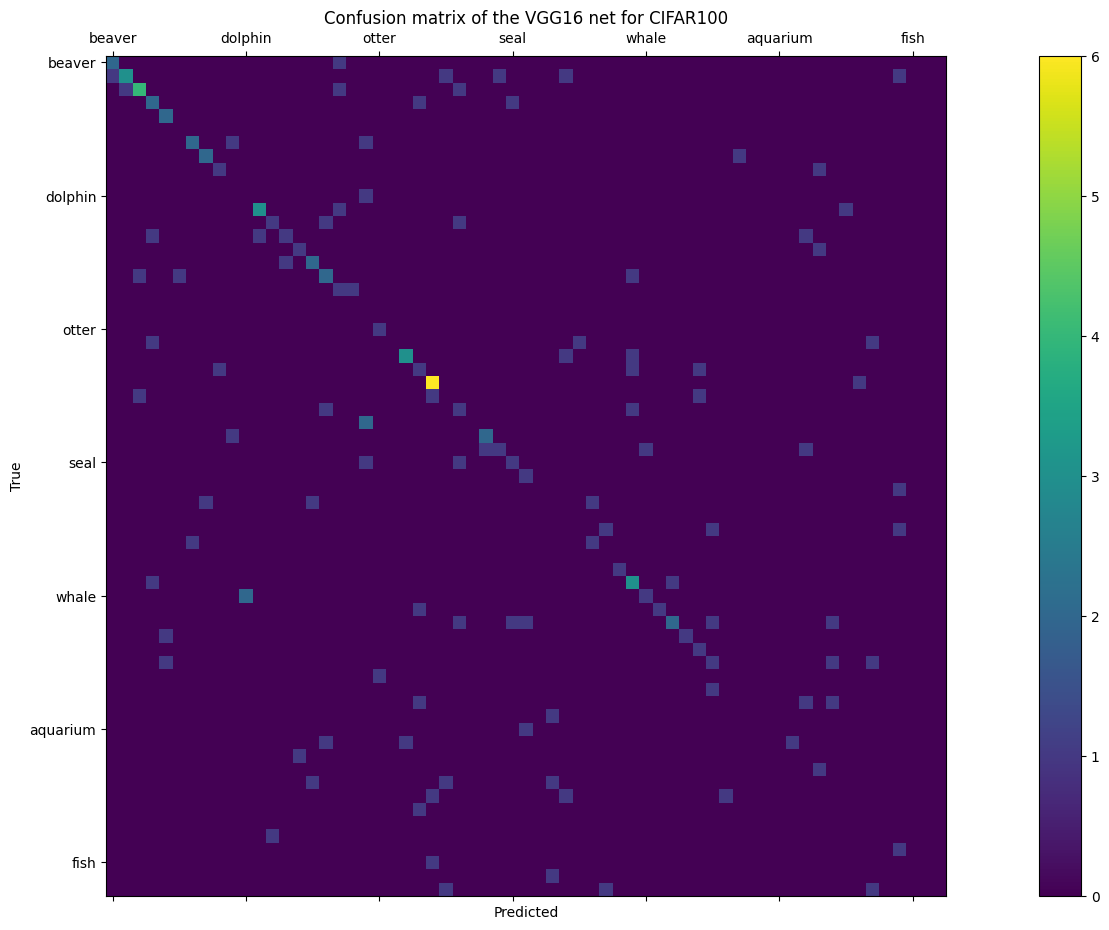

In [ ]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the VGG16 net for CIFAR100')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Calculating f1 score
from sklearn.metrics import f1_score
print(f"f1 score: {f1_score(y_true, y_pred, average='weighted')}")

f1 score: 0.39018455005716157


In [ ]:
labels = []
for i in range(100):
  labels.append(i+1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes, digits=5, labels =labels))

                   precision    recall  f1-score   support

           beaver    0.37500   0.75000   0.50000         4
          dolphin    0.57143   0.66667   0.61538         6
            otter    0.50000   0.40000   0.44444         5
             seal    1.00000   0.50000   0.66667         4
            whale    0.00000   0.00000   0.00000         1
         aquarium    0.50000   0.66667   0.57143         3
             fish    0.66667   0.66667   0.66667         3
              ray    0.50000   0.50000   0.50000         2
            shark    0.00000   0.00000   0.00000         2
            trout    0.00000   0.00000   0.00000         2
          orchids    0.60000   0.75000   0.66667         4
          poppies    0.33333   0.50000   0.40000         2
            roses    0.25000   0.50000   0.33333         2
       sunflowers    0.50000   0.50000   0.50000         2
           tulips    0.66667   0.50000   0.57143         4
          bottles    0.40000   0.40000   0.40000       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
average_time = sum(time_history)/len(time_history)
print('Average running time per epoch: %f min' %average_time)

Average running time per epoch: 13.172552 min


In [13]:
l_hist = []
for i in loss_history:
  i = i.cpu().detach().numpy()
  l_hist.append(i)

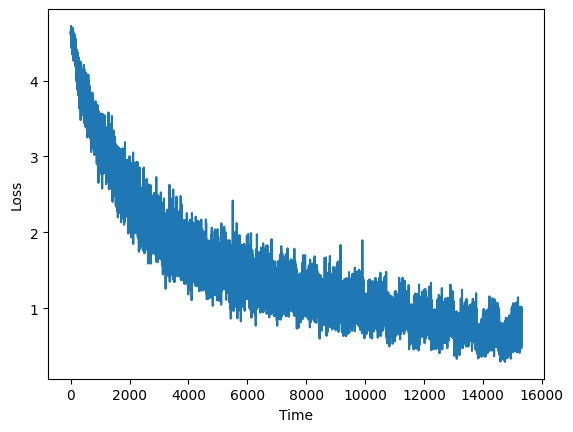

In [14]:
#Plot of loss history
import matplotlib.pyplot as plt
plt.plot(l_hist)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.show()

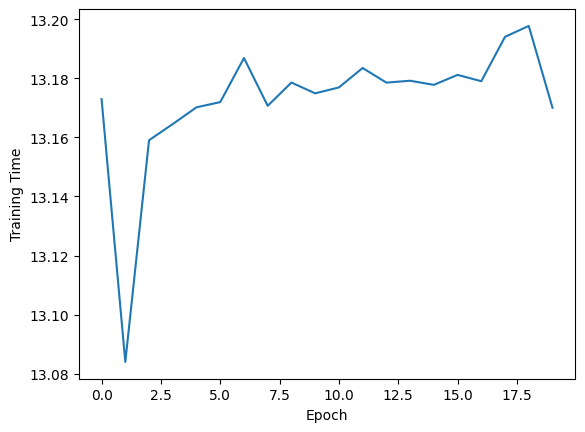

In [15]:
#Plot of training time
import matplotlib.pyplot as plt
plt.plot(time_history)
plt.ylabel('Training Time')
plt.xlabel('Epoch')
plt.show()